In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import norm
from scipy.integrate import quad
from scipy import optimize
from sklearn.preprocessing import StandardScaler

In [32]:
def ou_process(theta, mu, sigma, dt, T, X0):
    N = int(T/dt)
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X0
    for i in range(1, N):
        dX = mu * (theta - X[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        X[i] = X[i-1] + dX
    return t, X

In [35]:
def create_nn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
  ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [38]:
def F(x, theta, mu, sigma, r):
    def integrand(u):
        return u**(r/mu - 1) * np.exp(np.sqrt(2*mu/sigma**2) * (x-theta) * u - u**2/2)
    return quad(integrand, 0, np.inf)[0]

def G(x, theta, mu, sigma, r):
    def integrand(u):
        return u**(r/mu - 1) * np.exp(np.sqrt(2*mu/sigma**2) * (theta-x) * u - u**2/2)
    return quad(integrand, 0, np.inf)[0]

def V(x, b_star, c, theta, mu, sigma, r):
    if x <= b_star:
        return (b_star - c) * F(x, theta, mu, sigma, r) / F(b_star, theta, mu, sigma, r)
    else:
        return x - c

def find_optimal_levels(theta, mu, sigma, r, c):
    def objective(b):
        return V(b, b, c, theta, mu, sigma, r) - b
    
    b_star = optimize.brentq(objective, theta-10*sigma/np.sqrt(2*mu), theta+10*sigma/np.sqrt(2*mu))
    d_star = b_star + 2*c
    return b_star, d_star

In [41]:
class DeepMeanReversionTrader:
    def __init__(self, lookback=252, retrain_freq=63, transaction_cost=0.05, discount_rate=0.05):
        self.lookback = lookback
        self.retrain_freq = retrain_freq
        self.transaction_cost = transaction_cost
        self.discount_rate = discount_rate
        self.model = None
        self.scaler = StandardScaler()
        self.theta = None
        self.mu = None
        self.sigma = None
        self.b_star = None
        self.d_star = None
        self.beta = None
        self.in_position = False
        
    def preprocess_data(self, data):
        return self.scaler.fit_transform(data.reshape(-1, 1)).flatten()
    
    def train_model(self, data):
        X = np.array([data[i:i+self.lookback] for i in range(len(data)-self.lookback)])
        y = data[self.lookback:]
        
        self.model = create_nn_model((self.lookback,))
        self.model.fit(X, y, epochs=100, batch_size=32, verbose=0)
        
    def estimate_ou_parameters(self, data):
        dt = 1/252  # Assuming daily data
        returns = np.diff(data)
        self.theta = np.mean(data)
        self.mu = -np.log(np.sum(returns * data[:-1]) / np.sum(data[:-1]**2)) / dt
        self.sigma = np.std(returns) / np.sqrt(dt)
        
    def update_strategy(self, data):
        processed_data = self.preprocess_data(data)
        self.train_model(processed_data)
        self.estimate_ou_parameters(processed_data)
        self.b_star, self.d_star = find_optimal_levels(self.theta, self.mu, self.sigma, self.discount_rate, self.transaction_cost)
        self.beta = self.model.predict(processed_data[-self.lookback:].reshape(1, -1))[0][0]
        
    def trade(self, portfolio_value):
        if not self.in_position and portfolio_value <= self.b_star:
            self.in_position = True
            return 1  # Enter position
        elif self.in_position and portfolio_value >= self.d_star:
            self.in_position = False
            return -1  # Exit position
        return 0  # Hold

In [ ]:
Cell 6: Backtesting Function
  Implements backtest function
  Simulates strategy performance on historical data
  Calculates positions and returns over time

In [44]:
def backtest(data_A, data_B, trader):
    portfolio_values = data_A - trader.beta * data_B
    positions = np.zeros(len(data_A))
    returns = np.zeros(len(data_A))
    
    for i in range(trader.lookback, len(data_A)):
        if i % trader.retrain_freq == 0:
            trader.update_strategy(portfolio_values[i-trader.lookback:i])
        
        action = trader.trade(portfolio_values[i])
        positions[i] = action if action != 0 else positions[i-1]
        
        if action == 1:
            returns[i] = -trader.transaction_cost
        elif action == -1:
            returns[i] = positions[i-1] * (portfolio_values[i] - portfolio_values[i-1]) - trader.transaction_cost
        elif positions[i] != 0:
            returns[i] = positions[i] * (portfolio_values[i] - portfolio_values[i-1])
    
    return positions, returns

In [47]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define a list of popular stock tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]

# Create a list to store the results
results_list = []

# Get current date and date 1 year ago
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

for ticker in tickers:
    stock = yf.Ticker(ticker)
    
    # Fetch real-time data
    current_data = stock.history(period="1d")
    current_price = current_data['Close'].iloc[-1]
    day_change = ((current_price - current_data['Open'].iloc[0]) / current_data['Open'].iloc[0]) * 100

    # Fetch historical data for 52 week high/low
    hist_data = stock.history(start=start_date, end=end_date)
    week_52_high = hist_data['High'].max()
    week_52_low = hist_data['Low'].min()

    # Add data to results list
    results_list.append({
        "Ticker": ticker,
        "Current Price": round(current_price, 2),
        "Day Change %": round(day_change, 2),
        "52 Week High": round(week_52_high, 2),
        "52 Week Low": round(week_52_low, 2)
    })

# Create DataFrame from the results list
results = pd.DataFrame(results_list)

print("Real-time Stock Data:")
print(results)

# Calculate and print overall market trend
market_trend = results["Day Change %"].mean()
print(f"\nOverall Market Trend: {'Up' if market_trend > 0 else 'Down'} ({market_trend:.2f}%)")


Real-time Stock Data:
  Ticker  Current Price  Day Change %  52 Week High  52 Week Low
0   AAPL         220.91          0.04        236.96       163.67
1   MSFT         405.72         -0.37        467.51       307.14
2  GOOGL         148.71         -2.49        191.50       119.91
3   AMZN         175.40          0.50        201.20       118.35
4   NVDA         106.47          1.52        140.76        39.22

Overall Market Trend: Down (-0.16%)


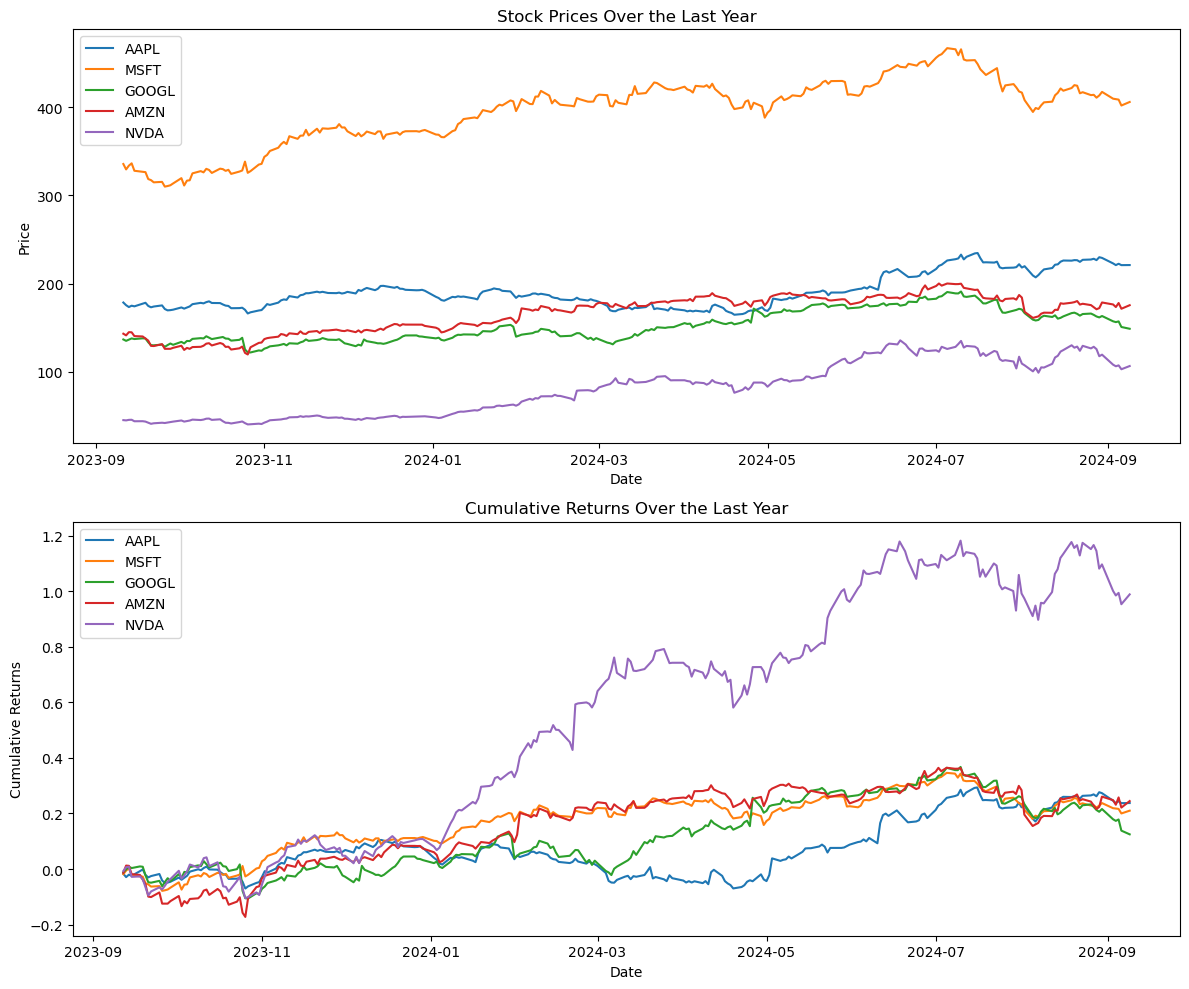

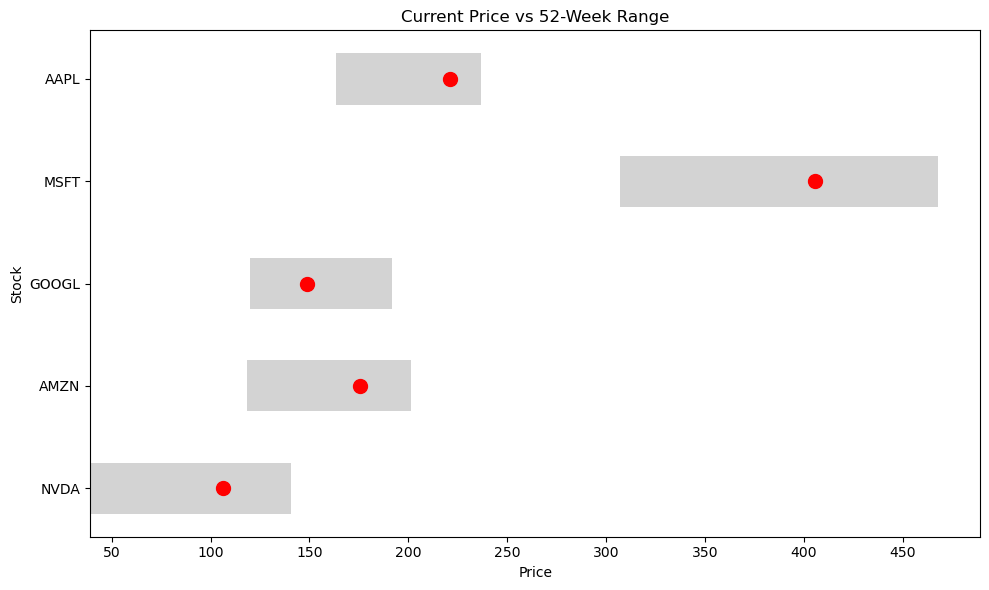

In [51]:
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# Fetch historical data for the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot stock prices
for ticker in tickers:
    stock_data = yf.Ticker(ticker).history(start=start_date, end=end_date)
    ax1.plot(stock_data.index, stock_data['Close'], label=ticker)

ax1.set_title('Stock Prices Over the Last Year')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()

# Plot daily returns
for ticker in tickers:
    stock_data = yf.Ticker(ticker).history(start=start_date, end=end_date)
    daily_returns = stock_data['Close'].pct_change()
    ax2.plot(stock_data.index, daily_returns.cumsum(), label=ticker)

ax2.set_title('Cumulative Returns Over the Last Year')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Returns')
ax2.legend()

plt.tight_layout()
plt.show()

# Additional visualization: Comparison of current price to 52-week range
fig, ax = plt.subplots(figsize=(10, 6))

for index, row in results.iterrows():
    ticker = row['Ticker']
    current_price = row['Current Price']
    low_52 = row['52 Week Low']
    high_52 = row['52 Week High']
    
    ax.barh(ticker, high_52 - low_52, left=low_52, height=0.5, color='lightgray')
    ax.plot([current_price], [ticker], 'ro', markersize=10)

ax.set_title('Current Price vs 52-Week Range')
ax.set_xlabel('Price')
ax.set_ylabel('Stock')
ax.invert_yaxis()  # To have the first stock at the top

plt.tight_layout()
plt.show()